# Task 3.1: Diverse Datasets


HIT01_8
                               entropy   jaccard
Answer.ID                     7.662591  1.000000
Question.ID                   7.658442  0.808081
Answer.duration               7.024122  1.000000
Answer.confidence             7.683782  0.555960
Answer.difficulty             7.759347  0.754747
Answer.order                  7.765796  0.457172
Code.LOC                      7.339980  0.484848
Code.complexity               7.588799  0.565657
Worker.score                  7.835589  0.626263
Worker.yearsOfExperience      7.462690  0.936566
Worker.age                    7.815515  0.956970
Answer.explanationComplexity  7.494021  0.975152
[-4.5183844566345215]
[-7.439603805541992]
[-7.529806613922119]
[-4.169291019439697]
[-0.07626225054264069]
[0.5766149163246155]
[-2.709165096282959]
[-1.353643536567688]
[-8.73869800567627]
[-8.485560417175293]
[-4.226334095001221]
[-6.7364821434021]
[-3.3610782623291016]
[-4.386577129364014]
[-0.863815188407898]
[-4.942454814910889]
[-1.8566812276840

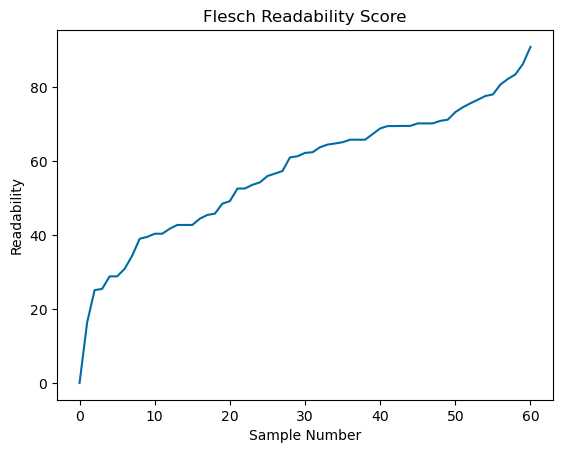

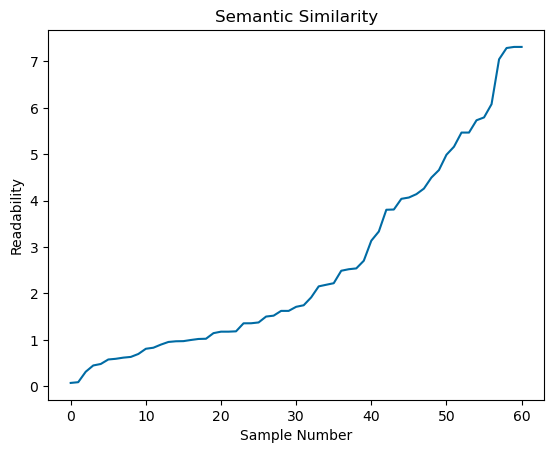

The value of minutes offset does not have valid argument as a result this method will not be called as and argument exception will be displayed.
(0.6165456771850586, 90.77) (3, 0.05)


In [88]:
import pandas as pd
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from main import prepare_data
from get_value_of_bug_description import Thinker

OUT_FOLDER = "diverse_datasets"


def semantic_similarity(s1, s2):
    tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-reranker-large')
    model = AutoModelForSequenceClassification.from_pretrained('BAAI/bge-reranker-large')
    model.eval()
    
    pairs = [[s1, s2]]
    with torch.no_grad():
        inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
        scores = model(**inputs, return_dict=True).logits.view(-1, ).float()
        print(scores.tolist())
        return scores.tolist()[0]
    

def jaccard_similarity(set1, set2):
    """
    Computes the Jaccard similarity between two sets.
    """
    union = set1 | set2
    if not union:  # both sets are empty
        return 1.0
    return len(set1 & set2) / len(union)

def average_jaccard_score(series, sample_size=100):
    """
    Calculates an average pairwise Jaccard diversity measure for a pandas Series.
    - First, each element is converted to a set of tokens (assuming a string).
    - Then, pairwise Jaccard similarities are computed.
    - Finally, diversity is defined as 1 - (average similarity),
      so that a lower average similarity means higher diversity
    To avoid heavy computation on large series, you may sample at most `sample_size` items.
    """
    # Drop missing values and convert each element to a set of words
    tokens = series.dropna().apply(lambda x: set(str(x).split()))
    tokens = tokens.tolist()
    
    n = len(tokens)
    if n < 2:
        return 0.0  # not enough items for a meaningful pairwise comparison

    comparisons = 0
    sim_sum = 0
    # Use a simple double loop, optionally limiting the number of comparisons via sample_size.
    limit = min(n, sample_size)
    for i in range(limit):
        for j in range(i + 1, limit):
            sim = jaccard_similarity(tokens[i], tokens[j])
            sim_sum += sim
            comparisons += 1

    # Average similarity
    avg_similarity = sim_sum / comparisons if comparisons > 0 else 0
    # Convert to a diversity measure where 1 indicates maximal diversity
    return 1 - avg_similarity

def diversity_score(df: pd.DataFrame):
    """
    Calculates two diversity measures for each feature (column) in the dataframe:
      - Entropy (using scipy.stats.entropy)
      - Jaccard diversity (if the column is textual)

    For textual columns this computes an average pairwise Jaccard similarity
    (then subtracts from 1 so that higher numbers mean higher diversity).
    For non-text columns (like numbers) the Jaccard diversity is set to None.
    """
    
    entropies = []
    jaccard_scores = []
    columns = df.columns.tolist()
    for column in columns:
        # Calculate the entropy using the raw values
        entropies.append(entropy(df[column].tolist()))
        jaccard_scores.append(average_jaccard_score(df[column]))
        
    # Combine entropy and Jaccard scores into a single DataFrame
    diversity_scores = pd.DataFrame({
        'entropy': entropies,
        'jaccard': jaccard_scores
    }, index=columns)
    return diversity_scores

def best_tuple_index_by_weighted_sum(metrics, weights=(1, 1)):
    """
    Returns the index of the tuple from 'metrics' that maximizes the weighted sum of its values.
    
    Parameters:
      metrics - a list of (metric1, metric2) tuples
      weights - a tuple (alpha, beta) where alpha is the weight for metric1 and 
                beta is the weight for metric2
                
    Returns:
      index of the tuple with the highest weighted sum
    
    Example:
      metrics = [(0.8, 0.9), (0.7, 0.95), (0.85, 0.85)]
      best_tuple_index_by_weighted_sum(metrics)  # returns index of best tuple
    """
    alpha, beta = weights
    current_max = -100
    current_idx = -1
    for idx, t in enumerate(metrics):
        v = t[0] * alpha + t[1] * beta
        if v > current_max:
            current_max = v
            current_idx = idx

    return current_idx


def number_of_words(expl, prompt_id: str, stdout=False):
    return len(expl.split(" "))

df = pd.read_csv("./data/answerList_data.csv")

methods = ["HIT01_8"]
gt = """
The predominant issue across these bug reports is the occurrence of an `IllegalArgumentException` being thrown due to an out-of-range `minutesOffset` value in a method that presumably handles time zone offset settings, such as `DateTimeZone.forOffsetHoursMinutes()`. The exception arises on line 280 because the code on line 279 checks if `minutesOffset` is less than 0 or greater than 59. As a key detail, passing a negative integer (e.g., -15) for `minutesOffset` triggers this exception. Various explanations suggest that based on the comments or documentation for the method, inputs for `minutesOffset` should allow negative values up to -59 if accompanied by negative hours, suggesting a mismatch between the method's implementation and its intended specification. Furthermore, numerous explanations highlight this inconsistency and suggest modifying the conditional check to accommodate the correct range of valid input values for `minutesOffset`. Additionally, there is mention of `NullPointerException` and `StringIndexOutOfBoundsException` in explanations, but these relate to different contexts or code portions not directly linked to the `minutesOffset` issue.
""".strip()

for method in methods:
    # Example usage: (make sure df has text columns when you want to evaluate jaccard diversity)
    # Only keep numerical features if you only care about entropy:
    print("\n" + method)
    _df = prepare_data(df, number_of_words, 'diverse_datasets')
    _df = df[df['FailingMethod'] == method]
    _df_num = df.select_dtypes(include=['int64', 'float64']).drop(['GroundTruth', 'TP', 'TN', 'FN', 'FP'], axis=1)    
    diversity_scores = diversity_score(_df_num)
    print(diversity_scores)

    all_texts = _df['Answer.explanation'].tolist()
    mean_entropy = diversity_scores['entropy'].mean()
    mean_jaccard = diversity_scores['jaccard'].mean()

    similarities_to_ground_truth = list(filter(lambda t: t[0] > 0, [
        (semantic_similarity(str(text), gt), textstat.flesch_reading_ease(str(text)))
        for text in all_texts
    ]))

    flesch_scores = [s[1] for s in similarities_to_ground_truth]
    flesch_scores.sort()
    semantic_similarities = [s[0] for s in similarities_to_ground_truth]
    semantic_similarities.sort()
    max_flesch, min_flesch, mean_flesch = flesch_scores[len(flesch_scores)-1], flesch_scores[0], np.mean(flesch_scores)
    
    print()
    print(f"Mean entropy: {mean_entropy}")
    print(f"Mean jaccard: {mean_jaccard}")
    print(f"Max Flesch: {max_flesch}, Min Flesch: {min_flesch}, Mean Flesch: {mean_flesch}")

    plt.style.use('tableau-colorblind10')
    plt.title("Flesch Readability Score")
    plt.xlabel("Sample Number")
    plt.ylabel("Readability")
    plt.plot(flesch_scores)
    plt.show()

    plt.style.use('tableau-colorblind10')
    plt.title("Semantic Similarity")
    plt.xlabel("Sample Number")
    plt.ylabel("Readability")
    plt.plot(semantic_similarities)
    plt.show()

    best_explanation = best_tuple_index_by_weighted_sum(similarities_to_ground_truth)
    print(all_texts[best_explanation])
    print(similarities_to_ground_truth[best_explanation], (3,0.05))